### Description: This script uses output from Allen Center segmentation tool for ZDR and KDP column related analysis. Creates all the subplots for Figure 16

In [1]:
import glob
import os
from datetime import datetime, timedelta

import matplotlib
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

# for dataframe compatibility of zdr object properties and matplotlib features for lightning plot
import pandas as pd
import skimage
import xarray as xr

# package for io
from aicsimageio import AICSImage, omeTifWriter
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# for eval function
from numpy import array
from scipy.ndimage import distance_transform_edt
from scipy.stats import norm
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops, regionprops_table
from skimage.morphology import (  # function for post-processing (size filter)
    ball,
    dilation,
    erosion,
    remove_small_objects,
    watershed,
)

# from aicssegmentation.cli.to_analysis import masked_builder, simple_builder
# from aicssegmentation.core.pre_processing_utils import (
#     image_smoothing_gaussian_slice_by_slice,
#     intensity_normalization,
# )

# function for core algorithm
# from aicssegmentation.core.seg_dot import (
#     dot_2d_slice_by_slice_wrapper,
#     dot_3d,
#     dot_3d_wrapper,
# )
# from aicssegmentation.core.utils import hole_filling
# from aicssegmentation.core.vessel import filament_2d_wrapper
# from aicssegmentation.core.visual import (
#     seg_fluo_side_by_side,
#     segmentation_quick_view,
#     single_fluorescent_view,
# )

# package for 3d visualization
# from itkwidgets import view

plt.rcParams["figure.figsize"] = [16, 12]
plt.rcParams["font.size"] = 13


plt.rcParams["figure.figsize"] = [12, 8]
plt.rcParams["font.size"] = 28
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 22
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 28
plt.rcParams["legend.fontsize"] = 22


# %load_ext autoreload
# %autoreload 2

In [2]:
# This part is important to understand and took me a while to actually grasp completely
# Had to store an RGB image from the output of gridding (could not use a simple binary image)
# Mainly because segmentation results identify separate objects in an RGB image much better.

# When we use plt.savefig to save the pcolormesh of ZDR field, matplotlib creates a figure with
# margins etc around the actual data axes. Also, because I saved it as a TIFF file with a dpi=300,
# the number of pixels in the resulting image DO NOT indicate the actual physical length in the data coordinates.

# Thus, we need to calculate the # pixels that actually represent the physical dimensions of the grid.
# For this purpose, I saved another plt.colormesh plot but this time with spines and axes features on
# Now, I can calculate the # pixels corresponding to the actual 120 km x and y dimensions of the grid using ImageJ.

# ImageJ reveals that the grid size of 120 km actually correspond to 2793 pixels in the x direction of the stack image.
# Since the y-dimension is smaller in our stack images, therefore, 1809 pixels in the y-direction correspond to 120 km.

x_resolution = 120 / 2793  # in km
y_resolution = 120 / 1809  # in km
z_resolution = 500  # in m, because z_res is also needed in calculation of zdr and kdp column heights


def my_annotate(
    ax, s, xy_arr=[], *args, **kwargs
):  # code taken from https://stackoverflow.com/a/14545981/12538451
    ans = []
    an = ax.annotate(s, xy_arr[0], *args, **kwargs)
    ans.append(an)
    d = {}
    try:
        d["xycoords"] = kwargs["xycoords"]
    except KeyError:
        pass
    try:
        d["arrowprops"] = kwargs["arrowprops"]
    except KeyError:
        pass
    for xy in xy_arr[1:]:
        an = ax.annotate(s, xy, alpha=0.0, xytext=(0, 0), textcoords=an, **d)
        ans.append(an)
    return ans

#### The stuff below was written with an intention to read in the batch processed segmented output.

#### Now, we calculate the ZDR column depth while reading each of the segmented images (after batch processing)

Below, we calculate the ZDR column depth of all the ZDR objects that were segmented and identified manually belonging to Edmond-Carney storm

We create a hierarchical indexed pandas dataframe to save zdr col depth for each identified zdr column at each time step

In [3]:
# After manual verification of all the ZDR column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data

# DO NOT change this!

obj_interest = [
    [1, 2],
    [1, 2],
    [1],
    [1],
    [3],
    [1],
    [2, 3],
    [2, 3, 4, 5],
    [3],
    [2],
    [2, 3],
    [2],
    [2],
    [2],
    [2],
    [3],
    [2],
    [1],
    [1],
    [1, 2],
    [2, 3],
    [3, 4, 5],
    [1, 2, 3],
    [2, 3],
    [1, 2, 3],
    [1, 2],
    [1, 2],
    [1, 2, 3],
    [1, 3],
    [1, 2],
    [1, 2, 3],
    [1, 2],
    [1, 2],
    [1, 2],
    [1, 2, 3],
    [1, 2, 3],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [4]:
# Here we load the segmentation output files and get datetime objects for each time step from radar files

segmented_files = sorted(
    glob.glob(os.path.expanduser("../data/processed/segmented_stacks/zdr/img_format/*.tiff"))
)

rad_files = sorted(glob.glob(os.path.expanduser("/Users/ms/Desktop/mount/May_19_2013_all_stuff/KTLX_data/*V06")))
tmpstmps = [
    x.split("/")[-1][4:19] for x in rad_files
]  # access the time stamps from each radar file and convert those into datetime objects
dt_tmpstmps = [datetime.strptime(x, "%Y%m%d_%H%M%S") for x in tmpstmps]

In [5]:
# This was done so as to save this data as a csv file to remember the object ids used for the segmented output for future references

df = pd.DataFrame(index=dt_tmpstmps, columns=["obj_id"])
for i in range(len(dt_tmpstmps)):
    df.at[dt_tmpstmps[i], "obj_id"] = obj_interest[i]

First, we derive a list of all the zdr objects identified by the segmentation algo with their labels. This info is stored in the 'full_list_areas' list

Next, we arrange it in a dataframe i.e. Multiindex dataframe with time and object_id as indices and z_levels as column names

In [6]:
# Here we create a mega dictionary which contains zdr column area data for each labeled object at each z-level

# However, mega_dict is a mess which needs to be organized into a clean dataframe type object.
# Therefore, we further process this info to create our dataframe in next cell.

mega_dict = []
for i in range(len(segmented_files)):
    cell_seg_reader = AICSImage(segmented_files[i])
    cell_seg = cell_seg_reader.data[0, 0, :, :, :]
    cell_seg_labeled = skimage.measure.label(cell_seg)
    dicts = []
    for j in range(cell_seg_labeled.shape[0]):
        try:
            dicts.append(
                regionprops_table(
                    cell_seg_labeled[j, :, :], properties=["area", "label"]
                )
            )
        except IndexError as error:
            dicts.append({})
    mega_dict.append(dicts)

In [7]:
# First step to create a dataframe is to extract a list of lists corresponding to each time step and all labeled objects at that time step

full_list_areas = []
for k in range(len(mega_dict)):
    tt1 = [d["label"] for d in mega_dict[k] if "label" in d]
    tt2 = [d["area"] for d in mega_dict[k] if "area" in d]

    objs = obj_interest[k]
    all_areas = []
    for m in range(len(objs)):
        obj_id = objs[m]
        areas = []
        for i in range(len(tt1)):
            if obj_id in tt1[i]:
                for j in range(len(tt1[i])):
                    if tt1[i][j] == obj_id:
                        areas.append(tt2[i][j])
            else:
                areas.append(0)

        if len(areas) < 15:
            N = 15 - len(areas)
            areas = np.pad(areas, (0, N), "constant")

        all_areas.append(areas)
    full_list_areas.append(all_areas)

In [8]:
# Now that we have a means to extract info for each object and its area at each z-level,  we proceed with creating a hierarchical index pandas dataframe

z_start = 4000
z_end = 11000
dz = 500

zlevels = np.arange(z_start, z_end + dz, dz)
zdr_area_df = pd.DataFrame()
for i in range(len(full_list_areas)):  # loop over all the time steps
    for j in range(len(obj_interest[i])):  # loop over all objects at a time step
        tm = dt_tmpstmps[i]
        lb = obj_interest[i][j]
        tf = pd.DataFrame(data=full_list_areas[i][j]).transpose()
        tf.index = pd.MultiIndex.from_arrays([[tm], [lb]], names=["time", "obj_id"])
        zdr_area_df = zdr_area_df.append(tf)
zdr_area_df.columns = zlevels  # assign z-levels as column names to our dataframe

In [9]:
# A multiindexed dataframe gives us enough flexibilty to perofrm further operations
# for example, we can use aggregation methods to calculate total area at each z-level and time step (and eventually plot a pcolormesh plot)

# we can also sum up areas of all objects at all z-levels at a particular time step to calculate volume of ZDR objects


# Let's calculate aggregated (sum of all objects; if #obj > 1) zdr area at each z-level first


zdr_area_all_zlevels = (
    zdr_area_df.sum(level="time").transpose() * x_resolution * y_resolution
)

# Now, let's calculate zdr volume at each time step

zdr_vol_ts = (
    zdr_area_df.sum(axis=1) * x_resolution * y_resolution * z_resolution / 1000.0
)  # Perform pixel to physical distance conversion to calculate the ZDR object volume in km3

zdr_vol_ts = pd.DataFrame(zdr_vol_ts, columns=["total_zdr_col_volume"])

In [10]:
zdr_vol_ts_new = pd.read_csv('zdr_vol_gt_1dB_pyart_based_segmentation')
zdr_vol_ts_new = zdr_vol_ts_new.set_index('time')
zdr_vol_ts_new.index = pd.to_datetime(zdr_vol_ts_new.index)
zdr_vol_ts_new = zdr_vol_ts_new.rename({'vol':'$Z_{DR}$ column volume'},axis=1)

tmp_zdr_vol_ts_new = pd.DataFrame(np.nan, index=dt_tmpstmps[len(zdr_vol_ts_new):], columns=['$Z_{DR}$ column volume'])
tmp_zdr_vol_ts_new.index.name = 'time'

zdr_vol_ts_new = zdr_vol_ts_new.append(tmp_zdr_vol_ts_new)

#### We performed image segmentation another way wherein we read the numpy array directly so that we can get the bounding boxes over identified objects and 
#### calculate the lightning initiation activity exactly within those regions. That analysis can be found in segment_from_grid_array_zdr.ipynb file

#### Since, the PyART and lmatools grids should exactly overlay for such analysis, we grid lightning data in a similar grid like our radar grids

#### The data is generated and saved only through the segment_from_grid_array_zdr.ipynb file

In [11]:
# load the flash initiation data from a saved text file (THIS IS THE TIME SERIES OF ONLY 2D PROJ OF FLASH INITIATION)

# Important: These flash initiation data were generated using 'segment_from_grid_array_directly.ipynb' file
# Since there was no way to identify the grid coordinates of zdr column objects from AICS image loading approach
# we moved to segmentation using direct numpy ndarray objects. This way, we could get the exact grid coordinates of
# the bounding boxes around the zdr column objects that we had segmented and manually chosen the ones which belonged
# to our region of interest. In order to calculate the flash initiation rates, we also had to grid our LMA data
# into a grid of exactly the same size and shape as our radar grid with KTLX as grid center. These grids correspond
# to flash information for exactly the same duration as each radar scan volume time. Please refer the
# flashsort_as_per_KTLX.ipynb file for more details.

# Thus, we had two grids of size (15,241,241) corresponding to (z,y,x) dimensions and we extracted the bbox coords
# for zdr col objects and eventually the corresponding grids on the 2D flash initiation grid. Thus, we could
# calculate the sum of all the flash initiations that lied within the region of zdr col objects.

initiation_df = pd.read_csv(
    os.path.expanduser(
        "../data/interim/zdr_col_analysis/flash_initiation_data_within_zdr_col_region/initiation_ts_df.txt"
    ),
    sep="\t",
)
initiation_df.index = initiation_df["Unnamed: 0"]
initiation_df = initiation_df.drop(labels=["Unnamed: 0"], axis=1)
initiation_df.index = pd.to_datetime(initiation_df.index)
initiation_ts_time = initiation_df.index

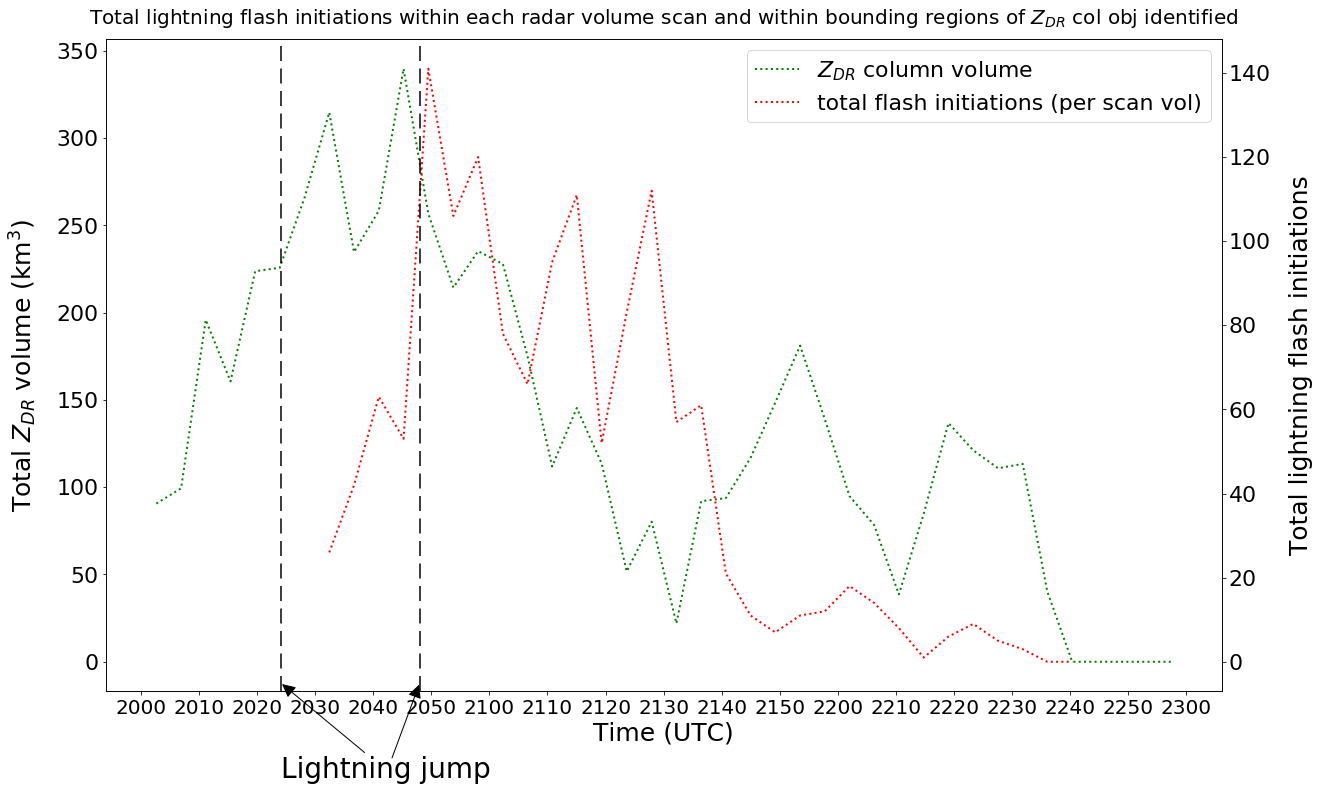

In [23]:
fig, ax = plt.subplots(figsize=(20, 12))
vplot1 = ax.plot_date(
    dt_tmpstmps,
    zdr_vol_ts_new.sum(level="time"),
    "g:",
    xdate=True,
    lw=2,
    label="$Z_{DR}$ column volume",
)
ax.set_ylabel("Total $Z_{DR}$ volume (km$^{3}$)", labelpad=18)
ax.set_xlabel("Time (UTC)")
ax1 = ax.twinx()
vplot2 = ax1.plot_date(
    initiation_ts_time,
    initiation_df,
    "r:",
    lw=2,
    label="total flash initiations (per scan vol)",
)
ax1.set_ylabel("Total lightning flash initiations", labelpad=18)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
vplots = vplot1 + vplot2
vlabs = [plot.get_label() for plot in vplots]
ax.legend(vplots, vlabs, loc=1,fontsize=22)
plt.title(
    "Total lightning flash initiations within each radar volume scan and within bounding regions of $Z_{DR}$ col obj identified",
    pad=15,fontsize=20
)
# plt.savefig(os.path.expanduser('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/individual_plots_for_panel_figures/ZDR_col_vol_flash_initiations.png'),
#             bbox_inches='tight',dpi=300)
my_annotate(
    ax1,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 20, 24, 0), -5),
        (datetime(2013, 5, 19, 20, 48, 0), -5),
    ],
    xycoords="data",
    xytext=(0, -95),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=1),
)

l1 = ax1.axvline((datetime(2013, 5, 19, 20, 24, 0)), linestyle="--", c="k")
l1.set_dashes([10, 5, 10, 5])
l2 = ax1.axvline((datetime(2013, 5, 19, 20, 48, 0)), linestyle="--", c="k")
l2.set_dashes([10, 5, 10, 5])

# plt.savefig('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/individual_plots_for_panel_figures/zdr_kdp_col_vol_flash_initiation_within_obj/ZDR_col_vol_flash_initiations1.png',dpi=300)
plt.show()

#### Similar analysis with KDP columns now

In [14]:
# These are from new segmentation performed on kdp array on Nov 28, 2020
kdp_obj_interest = [
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [8],
    [4],
    [7],
    [3, 8],
    [3],
    [4],
    [3],
    [2],
    [4, 6],
    [2],
    [1],
    [2],
    [5],
    [5],
    [2, 3],
    [4],
    [4],
    [2],
    [1],
    [2],
    [3, 4],
    [2],
    [3, 4],
    [3],
    [3],
    [1],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [15]:
nan_idx = [i for i, el in enumerate(kdp_obj_interest) if np.nan in el]

kdp_vol_ts_new = pd.read_csv('kdp_vol_gt_0.75degkm_pyart_based_segmentation')
kdp_vol_ts_new = kdp_vol_ts_new.set_index('time')
kdp_vol_ts_new.index = pd.to_datetime(kdp_vol_ts_new.index)
kdp_vol_ts_new = kdp_vol_ts_new.rename({'vol':'$K_{DP}$ column volume'},axis=1)

tmp_kdp_vol_ts_new = pd.DataFrame(np.nan, index=[dt_tmpstmps[dt] for dt in nan_idx], columns=['$K_{DP}$ column volume'])
tmp_kdp_vol_ts_new.index.name = 'time'

kdp_vol_ts_new = kdp_vol_ts_new.append(tmp_kdp_vol_ts_new)
kdp_vol_ts_new = kdp_vol_ts_new.reindex(labels=dt_tmpstmps)

In [29]:
# after manual verification of all the KDP column objects at the 4km level, we list out the ones that are embedded within Edmond-Carney storm
# This should filter out artifacts (due to gridding or contamination from nearby storms)
# each list within the obj_interest list specifies the object labels that are of our interest.
# There are 42 such lists in obj_interest corresponding to all the times for which we have gridded radar data
# The first eleven entries are nan because there was no realistic KDP object detected (at least did not appear so to my eye)

# DO NOT change this! elements of obj_interest list at indices 8 and 10 were added later (January 25, 2020) when I realized that they were traces of KDP columns there.

# This is the old one (not so useful now)
obj_interest = [
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
    [1],
    [1],
    [6],
    [1],
    [1],
    [1],
    [1],
    [1],
    [2],
    [1],
    [1],
    [1],
    [2],
    [1],
    [1, 2, 3],
    [1, 3],
    [1, 2],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [1],
    [np.nan],
    [np.nan],
    [np.nan],
    [np.nan],
]

In [16]:
# Since we had manually edited and removed some of the pixels mmisclassified as KDP column using napari and I don't want to repeat the process every time
# At the time of classification, I had saved the results into text files which can be loaded back here to calculate our statistics
# This way our calculations will be consistent and reproducible however many time we want to run this piece of code

df = pd.read_csv(
    os.path.expanduser(
        "./data_files/kdp_analysis/df_mega_dict_kdp_case_after_label_editing"
    ),
    header=0,
    delimiter="\t",
    usecols=None,
    engine="python",
)

df = df.drop(labels=["Unnamed: 0"], axis=1)
df.columns = [""] * len(df.columns)
df.index = [""] * len(df.index)

df1 = df.applymap(lambda x: x.strip() if type(x) == str else x)

df1.values.tolist()


eval(df1.values.tolist()[0][1])

# [float(f) for a in l for b in a for c in b for d in c for e in d for f in e]

dd = [eval(ele) for a in df1.values.tolist() for ele in a]

mega_dict = np.reshape(dd, [42, 15])

FileNotFoundError: [Errno 2] No such file or directory: './data_files/kdp_analysis/df_mega_dict_kdp_case_after_label_editing'

In [30]:
# First step to create a dataframe is to extract a list of lists corresponding to each time step and all labeled objects at that time step

full_list_areas = []
for k in range(len(mega_dict)):
    tt1 = [d["label"] for d in mega_dict[k] if "label" in d]
    tt2 = [d["area"] for d in mega_dict[k] if "area" in d]

    objs = obj_interest[k]
    all_areas = []
    for m in range(len(objs)):
        obj_id = objs[m]
        areas = []
        for i in range(len(tt1)):
            if obj_id in tt1[i]:
                for j in range(len(tt1[i])):
                    if tt1[i][j] == obj_id:
                        areas.append(tt2[i][j])
            else:
                areas.append(0)

        if len(areas) < 15:
            N = 15 - len(areas)
            areas = np.pad(areas, (0, N), "constant")

        all_areas.append(areas)
    full_list_areas.append(all_areas)

In [31]:
# Now that we have a means to extract info for each object and its area at each z-level,  we proceed with creating a hierarchical index pandas dataframe

z_start = 4000
z_end = 11000
dz = 500

zlevels = np.arange(z_start, z_end + dz, dz)
kdp_area_df = pd.DataFrame()
for i in range(len(full_list_areas)):  # loop over all the time steps
    for j in range(len(obj_interest[i])):  # loop over all objects at a time step
        tm = dt_tmpstmps[i]
        lb = obj_interest[i][j]
        tf = pd.DataFrame(data=full_list_areas[i][j]).transpose()
        tf.index = pd.MultiIndex.from_arrays([[tm], [lb]], names=["time", "obj_id"])
        kdp_area_df = kdp_area_df.append(tf)
kdp_area_df.columns = zlevels  # assign z-levels as column names to our dataframe

In [ ]:
# A multiindexed dataframe gives us enough flexibilty to perofrm further operations
# for example, we can use aggregation methods to calculate total area at each z-level and time step (and eventually plot a pcolormesh plot)

# we can also sum up areas of all objects at all z-levels at a particular time step to calculate volume of KDP objects


# Let's calculate aggregated (sum of all objects; if #obj > 1) kdp area at each z-level first

kdp_area_all_zlevels = (
    kdp_area_df.sum(level="time").transpose() * x_resolution * y_resolution
)

# Now, let's calculate kdp volume at each time step

kdp_vol_ts = (
    kdp_area_df.sum(axis=1) * x_resolution * y_resolution * z_resolution / 1000.0
)  # Perform pixel to physical distance conversion to calculate the KDP object volume in km3

kdp_vol_ts = pd.DataFrame(kdp_vol_ts, columns=["total_kdp_col_volume"])

In [16]:
# load the flash initiation data from a saved text file (THIS IS THE TIME SERIES OF ONLY 2D PROJ OF FLASH INITIATION)

# Important: These flash initiation data were generated using 'segment_from_grid_array_directly.ipynb' file
# Since there was no way to identify the grid coordinates of kdp column objects from AICS image loading approach
# we moved to segmentation using direct numpy ndarray objects. This way, we could get the exact grid coordinates of
# the bounding boxes around the kdp column objects that we had segmented and manually chosen the ones which belonged
# to our region of interest. In order to calculate the flash initiation rates, we also had to grid our LMA data
# into a grid of exactly the same size and shape as our radar grid with KTLX as grid center. These grids correspond
# to flash information for exactly the same duration as each radar scan volume time. Please refer the
# flashsort_as_per_KTLX.ipynb file for more details.

# Thus, we had two grids of size (15,241,241) corresponding to (z,y,x) dimensions and we extracted the bbox coords
# for kdp col objects and eventually the corresponding grids on the 2D flash initiation grid. Thus, we could
# calculate the sum of all the flash initiations that lied within the region of kdp col objects.

initiation_df = pd.read_csv(
    os.path.expanduser(
        "../data/interim/kdp_analysis/flash_initiation_data_within_kdp_col_region/initiation_ts_df.txt"
    ),
    sep="\t",
)
initiation_df.index = initiation_df["Unnamed: 0"]
initiation_df = initiation_df.drop(labels=["Unnamed: 0"], axis=1)
initiation_df.index = pd.to_datetime(initiation_df.index)
initiation_ts_time = initiation_df.index

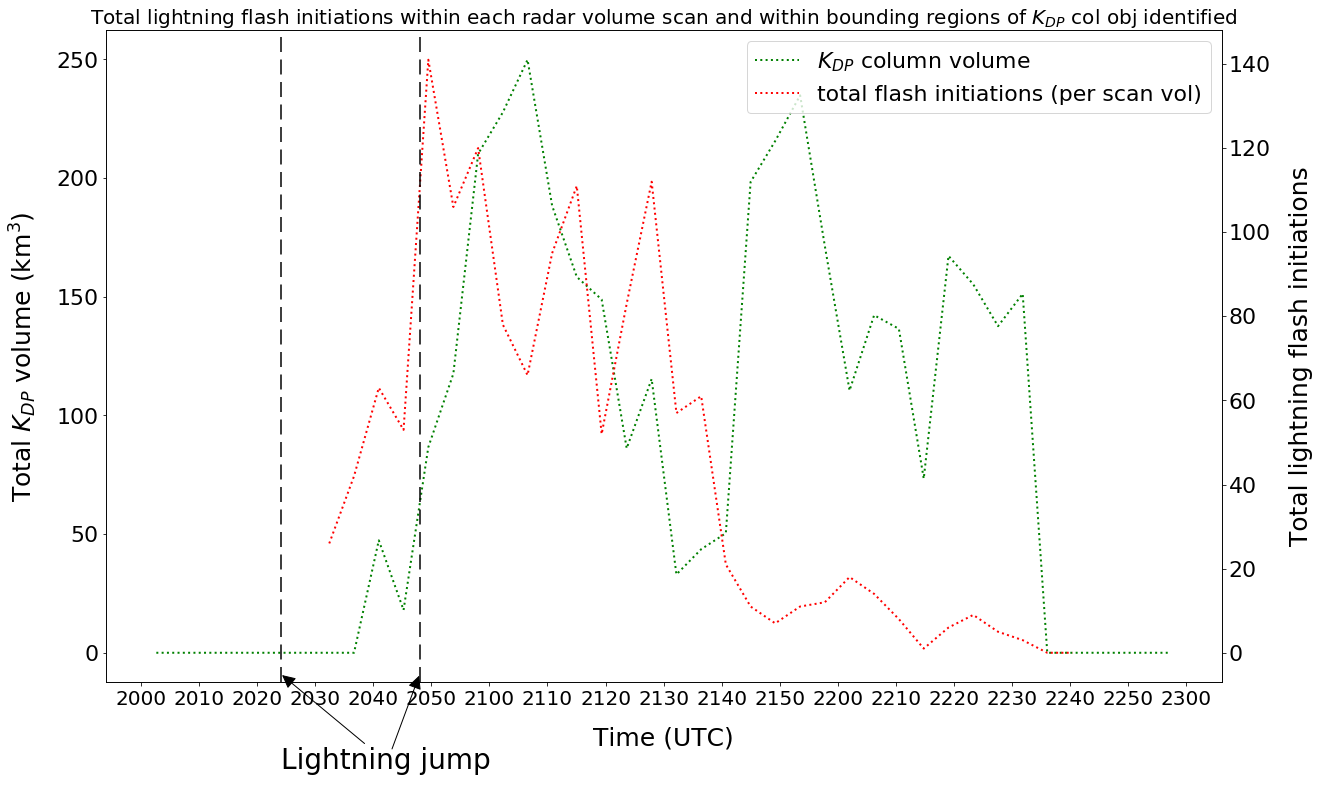

In [18]:
fig, ax = plt.subplots(figsize=(20, 12))
vplot1 = ax.plot_date(
    dt_tmpstmps,
    kdp_vol_ts_new.sum(level="time"),
    "g:",
    xdate=True,
    lw=2,
    label="$K_{DP}$ column volume",
)
ax.set_ylabel("Total $K_{DP}$ volume (km$^{3}$)", labelpad=18)
ax.set_xlabel("Time (UTC)", labelpad=18)
ax1 = ax.twinx()
vplot2 = ax1.plot_date(
    initiation_ts_time,
    initiation_df,
    "r:",
    lw=2,
    label="total flash initiations (per scan vol)",
)
ax1.set_ylabel("Total lightning flash initiations", labelpad=18)
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
vplots = vplot1 + vplot2
vlabs = [plot.get_label() for plot in vplots]
ax.legend(vplots, vlabs, loc=1)
plt.title(
    "Total lightning flash initiations within each radar volume scan and within bounding regions of $K_{DP}$ col obj identified",
    fontsize=20
)
# plt.savefig(os.path.expanduser('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/individual_plots_for_panel_figures/KDP_col_vol_flash_initiations.png'),
#             bbox_inches='tight',dpi=300)

my_annotate(
    ax1,
    "Lightning jump",
    xy_arr=[
        (datetime(2013, 5, 19, 20, 24, 0), -5),
        (datetime(2013, 5, 19, 20, 48, 0), -5),
    ],
    xycoords="data",
    xytext=(0, -95),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="-|>", connectionstyle="arc3,rad=0", fc="k", alpha=1),
)

l1 = ax1.axvline((datetime(2013, 5, 19, 20, 24, 0)), linestyle="--", c="k")
l1.set_dashes([10, 5, 10, 5])
l2 = ax1.axvline((datetime(2013, 5, 19, 20, 48, 0)), linestyle="--", c="k")
l2.set_dashes([10, 5, 10, 5])

plt.show()

In [ ]:
# Here, we plot the time series of ZDR column volumes at 0, 1,2,3,and 4km above ML to find out any hints

zdr_vol_ts_ML = (zdr_area_all_zlevels * 0.5).loc[4000, :]
zdr_vol_ts_1km_ML = (zdr_area_all_zlevels * 0.5).loc[5000, :]
zdr_vol_ts_2km_ML = (zdr_area_all_zlevels * 0.5).loc[6000, :]
zdr_vol_ts_3km_ML = (zdr_area_all_zlevels * 0.5).loc[7000, :]
zdr_vol_ts_4km_ML = (zdr_area_all_zlevels * 0.5).loc[8000, :]

fig = plt.figure(figsize=(18, 12))
ax = plt.gca()
zdr_vol_ts_ML.plot(ax=ax, label="0 km above ML")
zdr_vol_ts_1km_ML.plot(ax=ax, label="1 km above ML")
zdr_vol_ts_2km_ML.plot(ax=ax, label="2 km above ML")
zdr_vol_ts_3km_ML.plot(ax=ax, label="3 km above ML")
zdr_vol_ts_4km_ML.plot(ax=ax, label="4 km above ML")
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H%M"))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[0, 10, 20, 30, 40, 50]))
ax.set_ylabel("Z$_{DR}$ column volume (Km$^{3}$)")
ax.set_xlabel("Time (UTC)", labelpad=18)
ax.legend()
ax.tick_params(axis="x", which="major", pad=20, labelrotation=0)
plt.title(
    "Z$_{DR}$ column volume at different levels above melting layer (per radar volume scan)",
    pad=15,
)
# plt.savefig(os.path.expanduser('/Users/ms/Desktop/mount/May_19_2013_all_stuff/plots_LMA_May19_2013/manuscript_figures/final_png_files/ZDRcolvoltimeseriesdiffaltitude.png'),
#             bbox_inches='tight',dpi=300)
plt.show()